In [1]:
!module load tensorflow
!hostname
#Based on: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
#and https://github.com/nachi-hebbar/Transfer-Learning-ResNet-Keras/blob/main/ResNet_50.ipynb
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
os.environ ['KMP_AFFINITY'] = '64'

tensorflow/2.5.0-cuda-system unloaded
tensorflow/2.5.0-cuda-system loaded
c210-6


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
img_height,img_width=180,180
batch_size=128

In [3]:
strategy=tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#Double the batch size

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)#Double the batch size


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


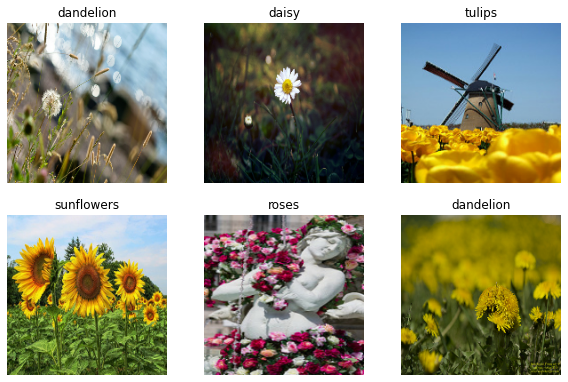

In [5]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
#strategy=tf.distribute.MirroredStrategy()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

with strategy.scope():
    resnet_model = Sequential()
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
    for layer in pretrained_model.layers:
        layer.trainable=False

    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dense(512, activation='relu'))
    resnet_model.add(Dense(5, activation='softmax'))
    resnet_model.summary()    
    resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Physical devices cannot be modified after being initialized
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/r

ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;0a011989c8f288de;/job:localhost/replica:0/task:0/device:GPU:0;ret_0;0:0
	 [[{{node RemoteCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNextAsOptional]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/ReadVariableOp_2/_58]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;0a011989c8f288de;/job:localhost/replica:0/task:0/device:GPU:0;ret_0;0:0
	 [[{{node RemoteCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNextAsOptional]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Adam/Adam/group_deps/NoOp/_95]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;0a011989c8f288de;/job:localhost/replica:0/task:0/device:GPU:0;ret_0;0:0
	 [[{{node RemoteCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNextAsOptional]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_24089]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()